Project Ideas


suggested project: analyze wind speed around the country with a view to a wind farm


## Project Plan

__Research wind farms in Ireland__

- where are they usually located?
- what wind conditions do they need? any other site considerations? Rural locations.
- how much electricity do they generate? summer vs winter?
- cost?
- lifespan?
- advantages
- disadvantages
- anything else?

__Project questions__

What's the relationship between wind speed and power generated? Does the wind direction affect power generation? 

Is there a trend in wind speed? Is Ireland getting winder? Variations across the year? Time of day?

Is the technology in wind turbines improving? Is more electricity being generated for the same wind speed?

Does rain/temperature/anything affect the output? 

What happens during a storm? Does amount of wind generated electricity decrease/increase? 

Predict power output for wind farms in Ireland for the next week. Tricky

As I have weather information could solar power to fill the gaps when wind speeds are low? Probably too big a task for this project. 


__Find data__

Weather data from met Éireann historical data.
    can select by site, perhaps initially analyse data for a number of weather stations near a wind farm and also weather stations not near a wind farm. From the data can I see why that site was selected?



Is there much variation in wind across the country? Eirgrid data for entire country. 

## Introduction

Background information

https://windenergyireland.com/about-wind/the-basics/facts-stats

## The Data

About the data set. 

## Organising and Cleaning the Data


Would be convenient to have all the data in one large data set. Need to research working with large data sets. More difficult to load than smaller data sets.

Clean data

In [43]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import random

## Wind Electricity Data

https://www.smartgriddashboard.com/#all

[Eirgrid real-time system information](https://www.eirgrid.ie/grid/real-time-system-information) . On the Eirgrid website it is only possible to view information for one day at a time and up to one month ago. Despite extensive searching I couldn't find an official source of Eirgrid historical data. I did find a [GitHub repository by Daniel Parke](https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main), who has written a very helpful python file to download all the historical data. His GitHub repository contains raw csv files for actual amount of electricity generated, actual demand, actual amount of electricity produced by wind for every year from 2014 for all Ireland, Northern Ireland and Republic of Ireland. I will need to run his program to get the most up to date data for 2024.

As my weather data is only for the Republic of Ireland, I am only interested in the csv files for the actual amount of electricity produced by wind for the Republic of Ireland. Each csv file containing one years worth of information was downloaded from the GitHub repository. After reading the data into pandas the next task will be to merge the files vertically using pd.concat(). Before I started on the onerous task of loading and concatenating each file separately, I came across a blog post on how to [read multiple csv file into pandas](https://saturncloud.io/blog/how-to-read-multiple-csv-files-into-python-pandas-dataframe). 

The solution to reading multiple files into pandas uses the glob module. Glob is a built-in module used to retrieve files/pathnames matching a specified pattern. It uses * wild cards to make path retrieval more simple and convenient. https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/. [Real python](https://realpython.com/get-all-files-in-directory-python/#conditional-listing-using-glob) states that glob.glob() returns a list of filenames that match a pattern, which in this case are csv files. 

```python
# Search for all csv files in the current working directory
import glob
glob.glob('*.csv')
```

Eirgrid have data on actual wind generation and the forecast wind generation. Could getting forecast information be of interest? Might help with machine learning. Github repository only contains actual data not forecast data. 


In [44]:
# This was the first step to create a single dataframe from multiple csv files. 

# Load the wind electricity files

# Find all csv files in the data/electricity directory
csv_files = glob.glob('data/electricity/*.csv')

# Create an empty dataframe to store the combined data
electricity_df = pd.DataFrame()

# Loop through each csv file and append contents to electricity_df
for csv_file in csv_files:
    df = pd.read_csv(csv_file, 
                     header = None, 
                     names = ['date', 'wind_actual', 'location', 'wind_value'], 
                     index_col= 'date',
                     parse_dates= ['date'],
                     usecols= ['date', 'wind_value'])
    electricity_df = pd.concat([electricity_df, df])
    electricity_df.sort_index(inplace= True)

electricity_df.head()

,wind_value
date,
2014-01-01 00:00:00,1020.0
2014-01-01 00:15:00,995.0
2014-01-01 00:30:00,933.0
2014-01-01 00:45:00,959.0
2014-01-01 01:00:00,921.0


In [45]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361152 entries, 2014-01-01 00:00:00 to 2024-01-01 21:45:00
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   wind_value  361004 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [46]:
electricity_df.isna().sum()

wind_value    148
dtype: int64

https://saturncloud.io/blog/how-to-find-all-rows-with-nan-values-in-python-pandas/

https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe

In [47]:
# View the rows with missing data
nan_rows = electricity_df[electricity_df.isna().any(axis= 1)]
nan_rows

,wind_value
date,
2014-03-30 01:00:00,NaN
2014-03-30 01:15:00,NaN
2014-03-30 01:30:00,NaN
2014-03-30 01:45:00,NaN
2015-03-29 01:00:00,NaN
...,...
2023-03-26 01:00:00,NaN
2023-03-26 01:15:00,NaN
2023-03-26 01:30:00,NaN


interpolate() vs ffill()

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html
https://www.geeksforgeeks.org/interpolation-in-python/

In [48]:
# Forward fill the missing rows
electricity_df.interpolate(method= 'linear', inplace= True)

have a lot of duplicated rows. csv files have data for the 1st jan for the following year. 

In [49]:
f'There are {electricity_df.index.duplicated().sum()} duplicated rows.'

'There are 10472 duplicated rows.'

https://stackoverflow.com/questions/13035764/remove-pandas-rows-with-duplicate-indices

In [50]:
# Remove any duplicated rows
electricity_df = electricity_df[~electricity_df.index.duplicated(keep= 'first')]
electricity_df.head()

,wind_value
date,
2014-01-01 00:00:00,1020.0
2014-01-01 00:15:00,995.0
2014-01-01 00:30:00,933.0
2014-01-01 00:45:00,959.0
2014-01-01 01:00:00,921.0


In [51]:
electricity_df.to_csv('data/electricity/clean_data/electricity_data.csv')

Electricity data recorded every 15min - resample to 1 hour as the weather information is recorded hourly.

In [52]:
hourly_electricity_df = electricity_df.resample('h').mean()
hourly_electricity_df.head()

,wind_value
date,
2014-01-01 00:00:00,976.75
2014-01-01 01:00:00,914.25
2014-01-01 02:00:00,938.50
2014-01-01 03:00:00,911.25
2014-01-01 04:00:00,915.00


In [53]:
hourly_electricity_df.to_csv('data/electricity/clean_data/hourly_electricity.csv')

In [54]:
hourly_electricity_df = pd.read_csv('data/electricity/clean_data/hourly_electricity.csv')
hourly_electricity_df.head()

,date,wind_value
0,2014-01-01 00:00:00,976.75
1,2014-01-01 01:00:00,914.25
2,2014-01-01 02:00:00,938.50
3,2014-01-01 03:00:00,911.25
4,2014-01-01 04:00:00,915.00


## Weather Data

The weather data was downloaded from historic met eireann sites. Data from a range of weather stations was downloaded. The selected weather stations were mostly based on their proximity to a wind farm. A number were selected for the size of the data set. To see if Ireland is getting windier. Oldest weather stations with data are Dublin airport and Valentia who have data from 1 Jan 1944. 

Met Eireann weather data is recorded hourly.

Weather Data

What I'm aiming to do

Look at wind speeds for the entire country. Is there much variability? Electricity generation values for the entire country. 

    Read all the csv files in weather directory into pandas.

        Problems: some csv files have a different numbers of rows to skip. Function to remove the unnecessary rows from csv file. 

        The dataframe would ideally be the location. This is proving very difficult. Have written a function to extract the location from file name. 

    Refine the dataframe to the years 2014 onwards. Write a function. 

    Merge the dataframes
        Can all the merging be done in one step? Write a function. 

Analyse the data. 


### Is there much variation in wind speed across the country? 

Electricity generated is given for ROI not broken down by wind farm.

Electricity data from 2014, so to compare wind speed and amount of electricity generated by wind only need weather data from 2014. 


Write a function to read in the weather data. Basic elements are the same skip rows, na_values, use columns, parse_dates

What columns are needed? 
date, rain, temp, msl, wdsp, wddir, 

sun, clht, clamt not recorded for all weather stations. so not of interest. 

Remove explanatory rows in csv file. 

In [55]:
csv_files = glob.glob('data/weather/*.csv')
print(csv_files)

['data/weather/hly1775Johnstown.csv', 'data/weather/hly875Mullingar.csv', 'data/weather/hly532DublinAirport.csv', 'data/weather/hly1875Athenry.csv', 'data/weather/hly1475Gurteen.csv', 'data/weather/hly518ShannonAirport.csv', 'data/weather/hly2075Finner.csv', 'data/weather/hly3904CorkAirport.csv', 'data/weather/hly2275Valentia.csv', 'data/weather/hly2375Belmullet.csv']


In [56]:
# Find all csv files in the data/weather
csv_files = glob.glob('data/weather/*.csv')

# Create an empty dataframe to store the combined data
weather_df = pd.DataFrame()

# Loop through each csv file and append contents to weather_df
for csv_file in csv_files:
    for skip_rows in [17, 23]:
        try:
            df = pd.read_csv(csv_file,
                             skiprows= skip_rows,
                             na_values= ' ',
                             index_col= 'date',
                             parse_dates= ['date'],
                             usecols= ['date', 'rain', 'temp', 'msl', 'wdsp', 'wddir'],
                             date_format = "%d-%b-%Y %H:%M"
                             )
        except Exception as e:
            continue
        
        weather_df = pd.concat([weather_df, df], axis= 1)

    weather_df.sort_index(inplace= True)

weather_df.head()

,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir,...,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir
date,,,,,,,,,,,,,,,,,,,,,
1944-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,9.3,1034.3,12.0,300.0,NaN,NaN,NaN,NaN,NaN
1944-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,8.9,1033.9,9.0,290.0,NaN,NaN,NaN,NaN,NaN
1944-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,9.4,1033.4,11.0,280.0,NaN,NaN,NaN,NaN,NaN
1944-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,9.3,1032.8,11.0,280.0,NaN,NaN,NaN,NaN,NaN
1944-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,8.6,1032.4,11.0,300.0,NaN,NaN,NaN,NaN,NaN


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)
vappr: -  Vapour Pressure (hPa)		             
rhum:  -  Relative Humidity (%) 
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (kt)
wddir: -  Predominant Wind Direction (deg)
ind:   -  Indicator

In [57]:
weather_df = weather_df['2014' :'2024']

In [58]:
weather_df.head()

,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir,...,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.0,7.6,992.4,13.0,220.0,0.0,3.4,989.8,8.0,180.0,...,0.0,7.5,988.7,9.0,180.0,0.0,7.1,984.0,17.0,210.0
2014-01-01 01:00:00,0.0,6.6,992.4,11.0,230.0,0.0,3.0,989.7,7.0,180.0,...,0.0,7.2,987.5,7.0,180.0,0.0,6.4,983.7,17.0,200.0
2014-01-01 02:00:00,0.0,6.7,991.7,9.0,210.0,0.0,3.0,989.1,7.0,180.0,...,0.3,8.4,986.2,9.0,180.0,0.1,7.2,983.2,15.0,200.0
2014-01-01 03:00:00,0.0,7.5,991.1,10.0,210.0,0.1,3.0,988.5,7.0,170.0,...,1.6,7.1,984.4,9.0,180.0,0.1,7.0,982.5,16.0,190.0
2014-01-01 04:00:00,0.0,8.0,989.6,11.0,200.0,0.0,2.8,987.4,7.0,160.0,...,0.8,7.7,981.9,8.0,160.0,1.0,6.6,981.6,16.0,190.0


In [59]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94969 entries, 2014-01-01 00:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    94940 non-null  float64
 1   temp    94941 non-null  float64
 2   msl     94941 non-null  float64
 3   wdsp    94935 non-null  float64
 4   wddir   94939 non-null  float64
 5   rain    94959 non-null  float64
 6   temp    94961 non-null  float64
 7   msl     94961 non-null  float64
 8   wdsp    94956 non-null  float64
 9   wddir   94959 non-null  float64
 10  rain    94969 non-null  float64
 11  temp    94969 non-null  float64
 12  msl     94969 non-null  float64
 13  wdsp    94969 non-null  int64  
 14  wddir   94969 non-null  float64
 15  rain    94956 non-null  float64
 16  temp    94957 non-null  float64
 17  msl     94869 non-null  float64
 18  wdsp    94943 non-null  float64
 19  wddir   94943 non-null  float64
 20  rain    94932 non-null  float

Check for missing data

In [60]:
weather_df.isna().sum()

rain      29
temp      28
msl       28
wdsp      34
wddir     30
rain      10
temp       8
msl        8
wdsp      13
wddir     10
rain       0
temp       0
msl        0
wdsp       0
wddir      0
rain      13
temp      12
msl      100
wdsp      26
wddir     26
rain      37
temp      28
msl       48
wdsp      35
wddir     23
rain       0
temp       0
msl        0
wdsp      11
wddir     11
rain       1
temp       0
msl        0
wdsp       0
wddir      0
rain       0
temp       0
msl        0
wdsp       0
wddir      0
rain       2
temp       0
msl        0
wdsp      44
wddir    109
rain       0
temp       0
msl        0
wdsp       0
wddir      0
dtype: int64

Fill missing data with mean of row before and after. 

https://stackoverflow.com/questions/54414269/pandas-filling-nans-by-mean-of-before-and-after-non-nan-values

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

interpolate

In [61]:
# https://stackoverflow.com/questions/30447083/python-pandas-return-only-those-rows-which-have-missing-values
null_data = weather_df[weather_df.isnull().any(axis=1)]
null_data

,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir,...,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir
date,,,,,,,,,,,,,,,,,,,,,
2014-10-29 15:00:00,0.0,11.7,1013.8,7.0,80.0,0.0,10.4,1014.1,NaN,100.0,...,0.0,13.8,1009.5,10.0,100.0,0.0,10.3,1011.8,10.0,120.0
2014-10-29 16:00:00,0.0,11.9,1013.6,7.0,70.0,0.0,10.3,1013.7,NaN,NaN,...,0.0,13.9,1009.0,11.0,90.0,0.0,10.3,1010.9,11.0,110.0
2014-10-29 17:00:00,0.1,12.3,1013.4,5.0,80.0,0.0,9.6,1013.6,NaN,260.0,...,0.0,14.4,1008.2,13.0,100.0,0.0,10.1,1010.1,10.0,120.0
2015-05-20 23:00:00,0.0,8.4,1025.1,8.0,270.0,0.0,6.7,1024.1,4.0,250.0,...,0.0,10.4,1026.5,8.0,NaN,0.0,9.9,1023.3,11.0,250.0
2015-05-21 00:00:00,0.0,7.5,1025.3,5.0,280.0,0.0,5.8,1024.4,4.0,230.0,...,0.0,10.5,1026.8,10.0,NaN,0.0,9.9,1023.5,12.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19 06:00:00,0.4,14.4,1012.3,8.0,190.0,0.0,12.2,1010.0,6.0,170.0,...,0.1,15.4,1007.7,10.0,170.0,0.0,15.0,1006.5,11.0,200.0
2024-08-19 07:00:00,0.2,14.8,1011.4,10.0,180.0,0.0,12.9,1009.6,6.0,180.0,...,3.0,14.9,1007.0,10.0,160.0,0.3,15.1,1005.5,14.0,200.0
2024-08-19 08:00:00,0.0,15.3,1011.2,9.0,190.0,0.0,13.8,1009.2,5.0,180.0,...,4.4,15.0,1003.6,14.0,160.0,3.8,12.7,1004.8,17.0,180.0


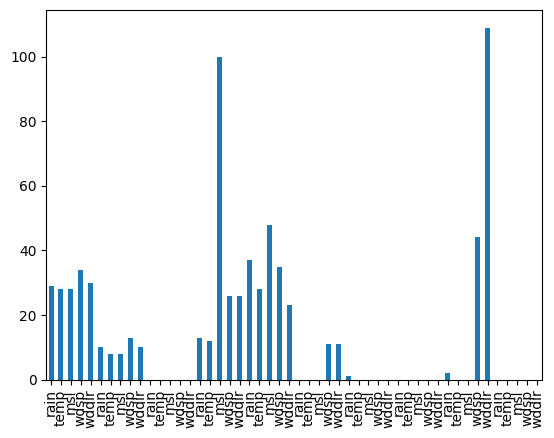

In [62]:
# Plot missing values
weather_df.isna().sum().plot(kind= 'bar')
plt.show()

In [63]:
weather_df.interpolate(method = 'linear', inplace= True)

In [64]:
#https://stackoverflow.com/questions/68233237/computing-row-average-of-columns-with-same-name-in-pandas
weather_df_mean = weather_df.T.groupby(weather_df.columns).mean().T

In [65]:
weather_df.head()

,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir,...,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.0,7.6,992.4,13.0,220.0,0.0,3.4,989.8,8.0,180.0,...,0.0,7.5,988.7,9.0,180.0,0.0,7.1,984.0,17.0,210.0
2014-01-01 01:00:00,0.0,6.6,992.4,11.0,230.0,0.0,3.0,989.7,7.0,180.0,...,0.0,7.2,987.5,7.0,180.0,0.0,6.4,983.7,17.0,200.0
2014-01-01 02:00:00,0.0,6.7,991.7,9.0,210.0,0.0,3.0,989.1,7.0,180.0,...,0.3,8.4,986.2,9.0,180.0,0.1,7.2,983.2,15.0,200.0
2014-01-01 03:00:00,0.0,7.5,991.1,10.0,210.0,0.1,3.0,988.5,7.0,170.0,...,1.6,7.1,984.4,9.0,180.0,0.1,7.0,982.5,16.0,190.0
2014-01-01 04:00:00,0.0,8.0,989.6,11.0,200.0,0.0,2.8,987.4,7.0,160.0,...,0.8,7.7,981.9,8.0,160.0,1.0,6.6,981.6,16.0,190.0


In [66]:
# Resample weather_df to monthly
monthly_weather = weather_df.resample('ME').mean()
monthly_weather.head()

,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir,...,rain,temp,msl,wdsp,wddir,rain,temp,msl,wdsp,wddir
date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.195027,6.314651,996.150806,10.677419,232.204301,0.197715,4.728495,993.961022,7.311828,203.239247,...,0.387231,7.668414,995.541801,13.020161,216.908602,0.282930,6.722446,991.028763,13.935484,217.352151
2014-02-28,0.260565,6.151042,991.138839,13.255952,225.744048,0.230506,4.972173,988.388244,9.321429,202.366071,...,0.434970,7.050893,989.852530,15.453869,218.898810,0.294643,6.292857,985.424256,15.409226,220.610119
2014-03-31,0.127151,7.098790,1014.239382,9.103495,215.268817,0.094220,6.315860,1013.165054,6.682796,199.583333,...,0.181855,7.995296,1013.980108,9.375000,200.604839,0.116935,7.603898,1011.685753,12.551075,204.233871
2014-04-30,0.093194,9.363194,1013.417222,7.930556,189.833333,0.075417,9.537222,1012.833750,6.355556,162.763889,...,0.118472,10.431528,1012.050972,8.927778,185.375000,0.074306,10.440000,1011.617639,10.325000,169.666667
2014-05-31,0.085484,11.278629,1014.389785,8.619624,198.481183,0.174328,11.076613,1013.836022,5.681452,199.556452,...,0.155376,11.444220,1014.955511,9.110215,198.709677,0.139247,11.510753,1013.404839,12.061828,168.642473


In [67]:
monthly_resample_summary = weather_df_mean.resample('ME').mean()
monthly_resample_summary.head()

,msl,rain,temp,wddir,wdsp
date,,,,,
2014-01-31,994.171546,0.232634,5.959583,212.538978,11.095027
2014-02-28,988.625595,0.273765,5.805521,212.659226,13.351339
2014-03-31,1013.295054,0.119543,7.067688,202.518817,9.739382
2014-04-30,1012.563875,0.077389,9.888083,176.025000,8.734583
2014-05-31,1014.107809,0.128387,11.335323,198.268817,8.716667


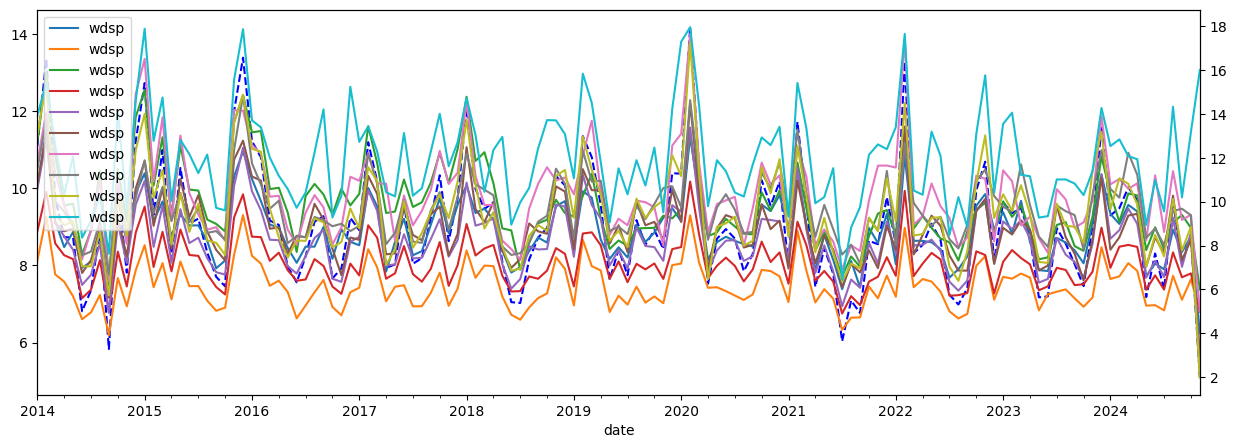

In [68]:

fig, ax = plt.subplots(figsize = (15,5))

monthly_resample_summary['wdsp'].plot(ax=ax, color = 'b', linestyle = 'dashed')

ax2 = ax.twinx()

monthly_weather['wdsp'].plot(ax= ax2)

plt.show()



Not ideal as I don't have the location names but if I had the location labelled in the data, I would have difficulty with the next step of merging the data based on mean

<Axes: xlabel='date'>

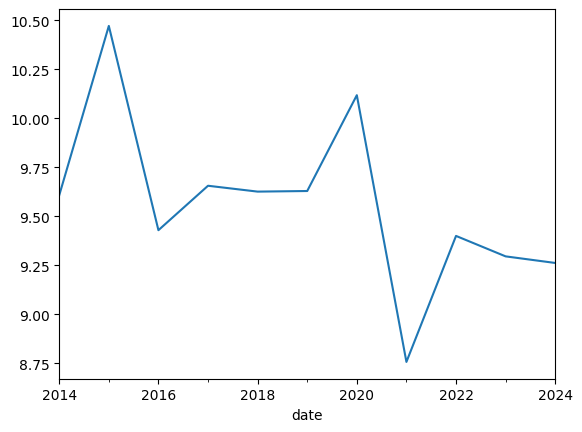

In [69]:
yearly_weather['wdsp'].plot()

In [70]:
yearly_electricity = electricity_df.resample('YE').mean()

<Axes: xlabel='date'>

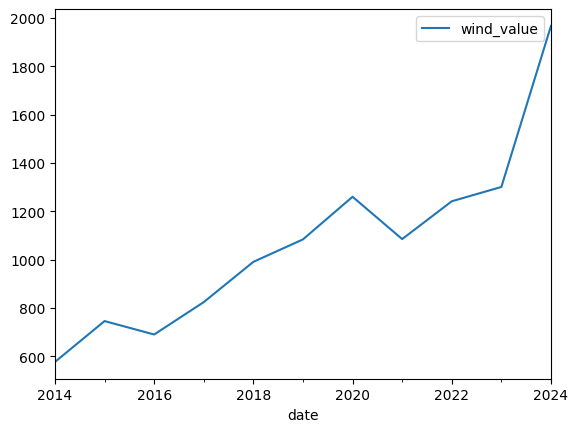

In [71]:
yearly_electricity.plot()

<Axes: xlabel='date'>

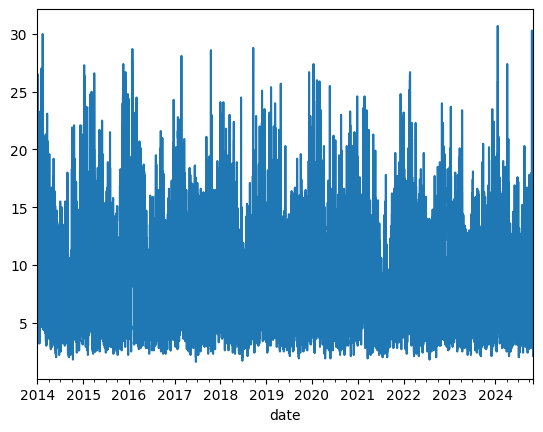

In [72]:
weather_df_mean['wdsp'].plot()

Possible Problem! 

Where is the pink line location? Much higher than all the other locations. 

Select another day. Is this a common trend? Should I add in more weather data locations?

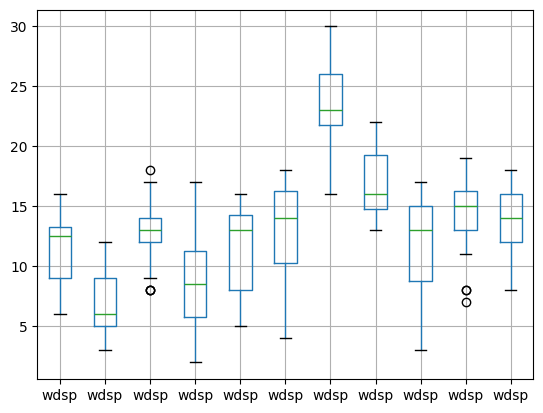

In [73]:
variation_df['wdsp'].boxplot()

plt.show()

In [74]:
weather_df_mean.to_csv('data/weather/merged_data/weather_mean.csv')

Merge weather dataframes



### Is Ireland getting windier? Use Dublin Airport data. Recorded from 1944. Also Valentia recorded from then too. Do Dublin first.

In [75]:
dublin_df = pd.read_csv('data/weather/hly532DublinAirport.csv', 
                        skiprows = 23, 
                        na_values = ' ',
                        index_col= 'date', 
                        parse_dates= ['date'], 
                        date_format = "%d-%b-%Y %H:%M")

dublin_df.head()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
date,,,,,,,,,,,,,,,,,,,,
1944-01-01 00:00:00,2,0.0,0,7.2,0,6.7,6.1,9.4,93.0,1027.9,1,19,1,290.0,50,5,0.0,20000.0,12.0,8.0
1944-01-01 01:00:00,0,0.0,0,7.2,0,6.6,6.1,9.3,91.0,1027.6,1,19,1,280.0,2,2,0.0,30000.0,15.0,7.0
1944-01-01 02:00:00,2,0.0,0,7.2,0,6.6,6.1,9.3,92.0,1027.0,1,19,1,260.0,50,5,0.0,30000.0,15.0,8.0
1944-01-01 03:00:00,2,0.0,0,7.2,0,6.5,5.5,9.1,90.0,1026.2,1,19,1,270.0,50,5,0.0,20000.0,15.0,7.0
1944-01-01 04:00:00,0,0.0,0,7.2,0,6.5,5.5,9.1,89.0,1025.5,1,19,1,270.0,2,2,0.0,30000.0,18.0,7.0


In [76]:
dublin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708601 entries, 1944-01-01 00:00:00 to 2024-11-01 00:00:00
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ind     708601 non-null  int64  
 1   rain    708601 non-null  float64
 2   ind.1   708601 non-null  int64  
 3   temp    708601 non-null  float64
 4   ind.2   708601 non-null  int64  
 5   wetb    708601 non-null  float64
 6   dewpt   708601 non-null  float64
 7   vappr   708600 non-null  float64
 8   rhum    708600 non-null  float64
 9   msl     708601 non-null  float64
 10  ind.3   708601 non-null  int64  
 11  wdsp    708601 non-null  int64  
 12  ind.4   708601 non-null  int64  
 13  wddir   708600 non-null  float64
 14  ww      708601 non-null  int64  
 15  w       708601 non-null  int64  
 16  sun     708601 non-null  float64
 17  vis     708257 non-null  float64
 18  clht    708577 non-null  float64
 19  clamt   708577 non-null  float64
dtypes: float64(12)

In [77]:
dublin_df = dublin_df.dropna()

In [78]:
dublin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708255 entries, 1944-01-01 00:00:00 to 2024-11-01 00:00:00
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ind     708255 non-null  int64  
 1   rain    708255 non-null  float64
 2   ind.1   708255 non-null  int64  
 3   temp    708255 non-null  float64
 4   ind.2   708255 non-null  int64  
 5   wetb    708255 non-null  float64
 6   dewpt   708255 non-null  float64
 7   vappr   708255 non-null  float64
 8   rhum    708255 non-null  float64
 9   msl     708255 non-null  float64
 10  ind.3   708255 non-null  int64  
 11  wdsp    708255 non-null  int64  
 12  ind.4   708255 non-null  int64  
 13  wddir   708255 non-null  float64
 14  ww      708255 non-null  int64  
 15  w       708255 non-null  int64  
 16  sun     708255 non-null  float64
 17  vis     708255 non-null  float64
 18  clht    708255 non-null  float64
 19  clamt   708255 non-null  float64
dtypes: float64(12)

In [79]:
dublin_monthly = dublin_df.resample('ME')

AttributeError: 'Series' object has no attribute 'scatterplot'

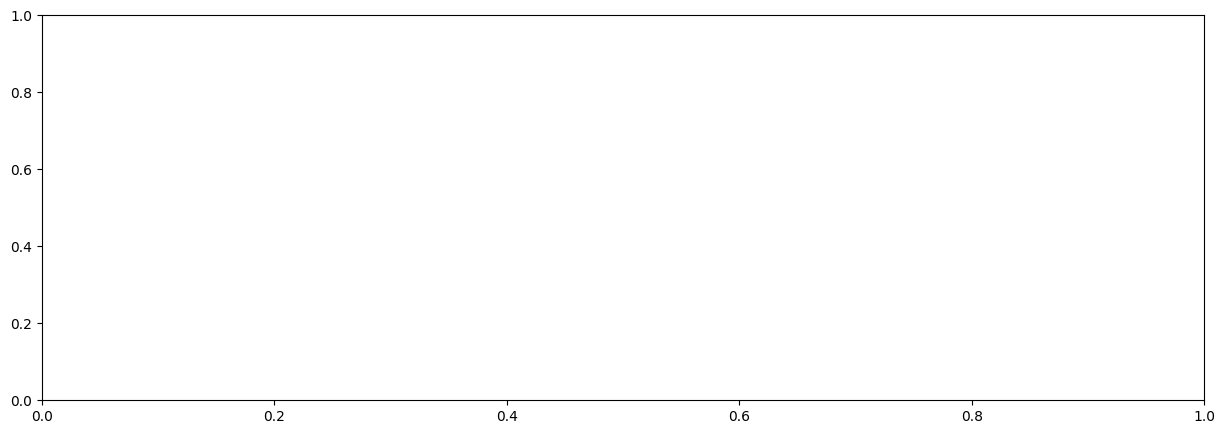

In [80]:
fig, ax = plt.subplots(figsize = (15, 5))

dublin_yearly = dublin_df.resample('YE')


dublin_df['wdsp'].resample('YE').mean().scatterplot()

plt.show()

In [ ]:
print(dublin_yearly['wdsp'].mean())

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(dublin_monthly['wdsp'].mean(), model= 'additive', period = 12)
fig = decomposition.plot()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
#from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
valentia_df = pd.read_csv('data/weather/hly2275Valentia.csv', 
                        skiprows = 23, 
                        na_values = ' ',
                        index_col= 'date', 
                        parse_dates= ['date'], 
                        date_format = "%d-%b-%Y %H:%M")

valentia_df.head()

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

valentia_df['wdsp'].resample('YE').mean().plot()

plt.show()

In [ ]:
valentia_monthly = valentia_df.resample('ME')

In [ ]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(valentia_monthly['wdsp'].mean(), model= 'additive', period = 12)
fig = decomposition.plot()


## Exploratory Data Analysis

In [ ]:
# Very quick plot of electricity generation by year

mean_wind_elect_year = electricity_df.resample('YE').mean()

mean_wind_elect_year.plot()
plt.show()

## Discussion of the Analysis

nice plots

## Machine Learning

some predictive analysis.

## Conclusion



## References


http://www.iwea.ie/technicalfaqs


### Data Sets

[GitHub Daniel Parke]https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main


__Problems that arose__

[Git LFS (large file storage)](https://git-lfs.com/). Some of the weather data filew were larger than GitHub's recommended maximum file size of 50.00 MB. Installed and used Git lfs
